In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax
import jax.numpy as np
from jax.numpy import array as arr
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp
from jax.scipy.special import expit as logistic

import numpyro as pn
from numpyro import sample
from numpyro import deterministic
import numpyro.distributions as dist
from numpyro.distributions import Normal as Norm
from numpyro.distributions import Exponential as Ex
from numpyro.distributions import Poisson as Pois
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import print_summary

import warnings
pn.set_platform("cpu")
pn.set_host_device_count(4)

/Users/sasha/miniforge3/envs/pyro/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_formats = ["svg"]
%load_ext watermark
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)
%watermark -n -u -v -iv -w

Last updated: Thu Sep 08 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

numpyro   : 0.10.1
matplotlib: 3.5.3
jax       : 0.3.17
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:38:29) [Clang 13.0.1 ]
pandas    : 1.4.4
arviz     : 0.12.1

Watermark: 2.3.1



In [3]:
def z(x):
    return (x - x.mean()) / x.std()
    
## for jax's RNG
def key_gen(seed = random.PRNGKey(8927)):
    def key():
        nonlocal seed
        seed, new_key = random.split(seed)
        return new_key
    return key

key = key_gen()

In [4]:
Panda_nuts = pd.read_csv("Data/Panda_nuts.csv", sep=";")

In [5]:
dat_list = dict(
    n=Panda_nuts.nuts_opened.values,
    age=Panda_nuts.age.values / Panda_nuts.age.max(),
    seconds=Panda_nuts.seconds.values,
)

def model(seconds, age, n):
    phi = sample("phi", dist.LogNormal(np.log(1), 0.1))
    k = sample("k", dist.LogNormal(np.log(2), 0.25))
    theta = sample("theta", dist.LogNormal(np.log(5), 0.25))
    lambda_ = seconds * phi * (1 - np.exp(-k * age)) ** theta
    sample("n", Pois(lambda_), obs=n)

m16_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m16_4.run(key(), **dat_list)

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/1000 [00:02<?, ?it/s]

Running chain 3: 100%|██████████| 1000/1000 [00:02<00:00, 430.55it/s]


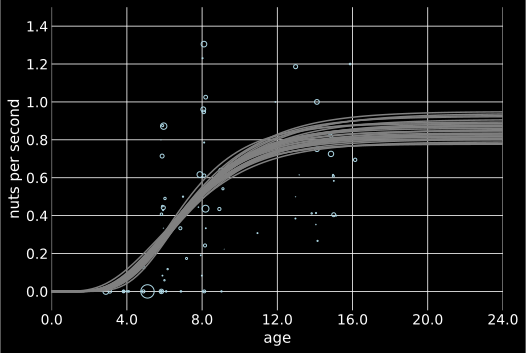

In [6]:
post = m16_4.get_samples()
_,ax = plt.subplots()
xt = arr([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xlim=(0, 1), ylim=(-0.1, 1.5), xlabel="age", ylabel="nuts per second", xticks=xt, xticklabels=np.round(xt * Panda_nuts.age.max()))

# raw data
pts = dat_list["n"] / dat_list["seconds"]
normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
point_size = normalize(dat_list["seconds"])
eps = (dat_list["age"][1:] - dat_list["age"][:-1]).max() / 5
jitter = eps * dist.Uniform(-1, 1).sample(key(), dat_list["age"].shape)
plt.scatter(dat_list["age"] + jitter, pts, s=(point_size * 3) ** 2 * 20, color="lightblue", facecolors="none",)

x = np.linspace(0, 1.5, 101)
for i in range(30):
    plt.plot(x, post["phi"][i] * (1 - np.exp(-post["k"][i] * x)) ** post["theta"][i], "gray")

Text(19, 50, 'Lynx')

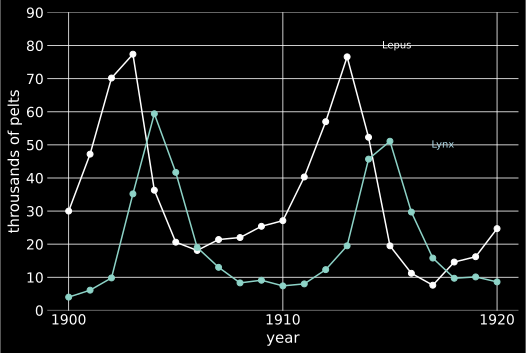

In [7]:
Lynx_Hare = pd.read_csv("Data/Lynx_Hare.csv", sep=";")
plt.plot(np.arange(1, 22), Lynx_Hare.iloc[:, 2], "wo-", lw=1.5)
plt.gca().set(ylim=(0, 90), xlabel="year", ylabel="throusands of pelts")
xt = arr([1, 11, 21])
plt.gca().set(xticks=xt, xticklabels=Lynx_Hare.Year.iloc[xt - 1])
plt.plot(np.arange(1, 22), Lynx_Hare.iloc[:, 1], "o-", lw=1.5)
plt.annotate("Lepus", (17, 80), color="w", ha="right", va="center")
plt.annotate("Lynx", (19, 50), color="lightblue", ha="right", va="center")

<AxesSubplot:>

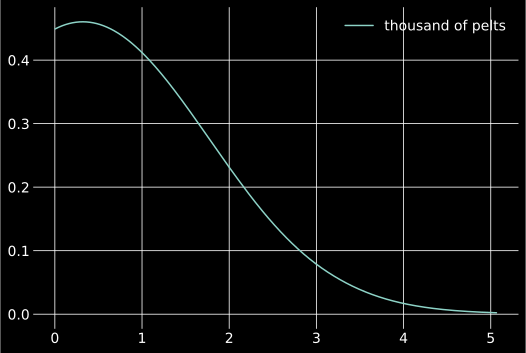

In [8]:
N = int(1e4)
Ht = int(1e4)
p = dist.Beta(2, 18).sample(key(), (N,))
h = dist.Binomial(Ht, p).sample(key())
h = np.round(h / 1000, 2)
az.plot_kde(h, label="thousand of pelts", bw=1)

In [9]:
def dpop_dt(pop_init, t, theta):
    """
    :param pop_init: initial state {lynx, hares}
    :param t: time
    :param theta: parameters
    """
    L, H = pop_init[0], pop_init[1]
    bh, mh, ml, bl = theta[0], theta[1], theta[2], theta[3]
    # differential equations
    dH = (bh - mh * L) * H
    dL = (bl * H - ml) * L
    return np.stack([dL, dH])

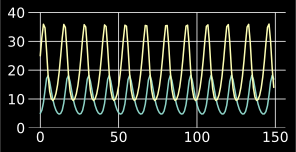

In [10]:
s_sol = odeint(dpop_dt, [5.0, 25.0], np.arange(150.0), [0.5, 0.05, 0.5, 0.025],
        rtol=1e-4, atol=1e-4, mxstep=100)
_, ax = plt.subplots(figsize=[4,2])
ax.set_ylim(0, 40)
ax.plot(s_sol[0])
ax.plot(s_sol[1]);

In [11]:
def Lynx_Hare_model(timepoints, pelts=None):
    """
    :param int N: number of measurement times
    :param pelts: measured populations
    """
    # priors
    # bh,mh,ml,bl
    theta = sample("theta",
        dist.TruncatedNormal(low=0.0, 
                            loc=np.tile(arr([1, 0.05]), 2), 
                            scale=np.tile(arr([0.5, 0.05]), 2)))
    # measurement errors
    sigma = sample("sigma", dist.Exponential(1), sample_shape=(2,))
    # trap rate
    p = sample("p", dist.Beta(40, 200), sample_shape=(2,))
    # initial population state
    pop_init = sample("pop_init", dist.LogNormal(np.log(10), 1), sample_shape=(2,))

    pop = deterministic("pop",
                        odeint(dpop_dt, pop_init, timepoints, theta, 
                            rtol=1e-5, atol=1e-5, mxstep=500))

    sample("pelts", dist.LogNormal(np.log(pop * p), sigma), obs=pelts)

In [ ]:
dat_list = dict(timepoints=np.arange(float(Lynx_Hare.shape[0])), pelts=Lynx_Hare.values[:, 1:3])

m16_5 = MCMC(NUTS(Lynx_Hare_model, target_accept_prob=0.95),
        num_warmup=1000, num_samples=1000, num_chains=3)
        #num_warmup=1000, num_samples=1000, num_chains=3)
m16_5.run(key(), **dat_list)

In [13]:
m16_5.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       p[0]      0.17      0.02      0.17      0.13      0.21   1600.39      1.00
       p[1]      0.18      0.02      0.18      0.14      0.22   1083.15      1.00
pop_init[0]     34.47      5.80     33.82     24.92     43.41   1379.57      1.00
pop_init[1]    188.49     30.28    185.99    141.70    238.74   1268.81      1.00
   sigma[0]      0.26      0.05      0.25      0.19      0.33   2166.89      1.00
   sigma[1]      0.25      0.04      0.24      0.18      0.32   2097.10      1.00
   theta[0]      0.55      0.06      0.54      0.44      0.64   1161.06      1.00
   theta[1]      0.00      0.00      0.00      0.00      0.01   1422.67      1.00
   theta[2]      0.81      0.09      0.80      0.67      0.96   1088.21      1.00
   theta[3]      0.00      0.00      0.00      0.00      0.01    841.91      1.00

Number of divergences: 0


In [18]:
az.summary(m16_5, var_names=['~pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.174,0.024,0.131,0.219,0.001,0.000,1603.0,1743.0,1.0
p[1],0.181,0.024,0.137,0.224,0.001,0.001,1117.0,1298.0,1.0
pop_init[0],34.470,5.801,24.415,45.790,0.156,0.111,1416.0,1573.0,1.0
pop_init[1],188.485,30.276,132.322,242.736,0.848,0.600,1249.0,1463.0,1.0
sigma[0],0.256,0.047,0.182,0.349,0.001,0.001,2732.0,1991.0,1.0
sigma[1],0.250,0.045,0.177,0.337,0.001,0.001,2392.0,1749.0,1.0
theta[0],0.545,0.063,0.429,0.664,0.002,0.001,1174.0,1163.0,1.0
theta[1],0.005,0.001,0.003,0.007,0.000,0.000,1446.0,1677.0,1.0
theta[2],0.806,0.091,0.647,0.986,0.003,0.002,1100.0,1174.0,1.0
theta[3],0.004,0.001,0.003,0.006,0.000,0.000,849.0,1159.0,1.0


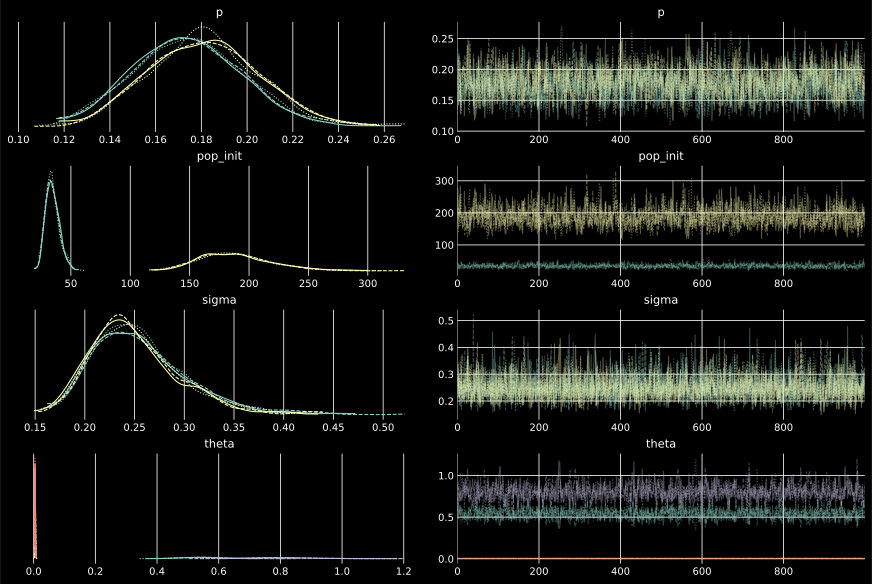

In [19]:
az.plot_trace(m16_5, var_names=['~pop']);

In [20]:
predict = Predictive(Lynx_Hare_model, m16_5.get_samples(), return_sites=["pelts", "pop"])
post = predict(key(), np.arange(50.0))
pelts = dat_list["pelts"]

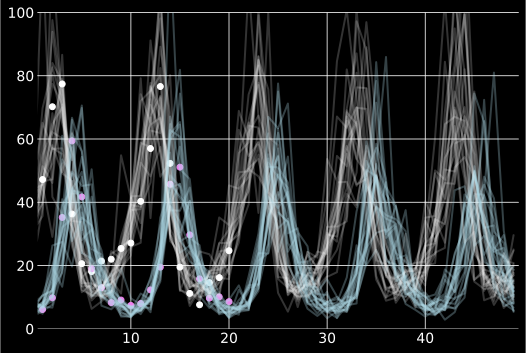

In [24]:
ax = plt.subplot(xlim=(0.5, 49.5), ylim=(0, 100))
ax.plot(pelts[:, 1], "wo")
ax.plot(pelts[:, 0], "o", color='violet')
# 21 time series from posterior
for s in range(21):
    ax.plot(post["pelts"][s, :, 1], "w", alpha=0.2, lw=2)
    ax.plot(post["pelts"][s, :, 0], "lightblue", alpha=0.3, lw=2)


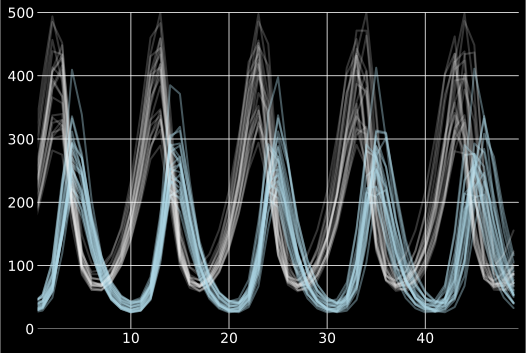

In [25]:
ax = plt.subplot(xlim=(0.5, 49.5), ylim=(0, 500))
for s in range(21):
    ax.plot(post["pop"][s, :, 1], "w", lw=2, alpha=0.2)
    ax.plot(post["pop"][s, :, 0], "lightblue", lw=2, alpha=0.4)